# Entity Recogntion Task - BiLSTM with Word Embedding

Dataset:
- Abhinav Walia(2018) - https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv

Reference code on Kaggle:
- Khoadodox (2021) - https://www.kaggle.com/anhkhoado/ner-bilstm
- Jay Sinha (2021) - https://www.kaggle.com/razor08/ner-with-bilstm
- skiller (2021) - https://www.kaggle.com/skiller/ner-pytorch-masked-accuracy-and-loss
-  Mathurin Aché(2020) https://www.kaggle.com/mathurinache/name-entity-recognition
There might be other methods thay I found online that have added the corresponding link to the cell.

Import and Preleminaries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf

Ignore the following code if you are running from you local. Load the NER dataset.

In [ ]:
# Upload the data to google cloud in case the drag-drop upload is not working.
# This was the case on my side
from google.colab import files
dataset_file_dict = files.upload()

Saving ner_dataset.csv to ner_dataset.csv


Read the file. As I am using Colab the file are stored in `content/filename`. Change the file path as you need if you want to use it locally

### Dataset Load

In [ ]:
data = pd.read_csv("/content/ner_dataset.csv", encoding = "ISO-8859-1", error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data.isna().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [ ]:
data = data.fillna(method='ffill')

In [ ]:
data.isna().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


### Dataset Processing

In [ ]:
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [ ]:
num_words, num_tags

(35179, 17)

In [ ]:
### Retrieve Sentences and correspondin Tags
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w,p,t) for w, p, t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

Map sentences and tags together

In [ ]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i,t, in enumerate(tags)}

In [ ]:
vocab = [w for  w in words]
len(vocab)

35179

In [ ]:
word2idx

In [ ]:
tag2idx

{'B-art': 0,
 'B-eve': 12,
 'B-geo': 15,
 'B-gpe': 13,
 'B-nat': 8,
 'B-org': 6,
 'B-per': 3,
 'B-tim': 10,
 'I-art': 14,
 'I-eve': 1,
 'I-geo': 7,
 'I-gpe': 16,
 'I-nat': 9,
 'I-org': 5,
 'I-per': 11,
 'I-tim': 2,
 'O': 4}

### Sequence Padding and processing

Make the input sequence the same length by using paddinga nd then split the data for testing and training

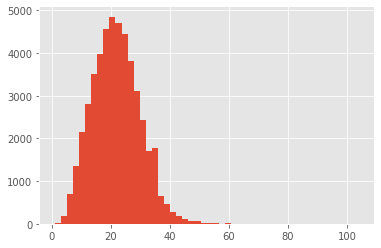

In [ ]:
### Checking distribution of sentences length
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
# Max length seems to be around 50
max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences = X, padding='post', value=num_words-1)
test = [w[0] for w in sentences[0]]
print(test)
print(X[0])
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences = y, padding='post', value= tag2idx["O"])
print(y)
print(y.shape)
y = [to_categorical(i, num_classes=num_tags) for i in y]


['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
[ 9903 24308 21826 24495  9674  5336 29665 29283  5045 34134 29449 17815
  8088 13726 27436 34134 27955 24308 25807 13241 10057 11001 12106 20541
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
[[10 10 10 ... 10 10 10]
 [ 8 10 10 ... 10 10 10]
 [10 10  2 ... 10 10 10]
 ...
 [10 16 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10  7 11 ... 10 10 10]]
(47959, 50)


I connected my drive as I have already uploaded the files there, and since I am using Google Colab, I had to reupload after reinitializing every session. For this reason I am using my drive. If you have the files locally then you can use them.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load the embedding from drive.

You need to specify different paths if you are running locally or from you own drive.

In [ ]:
enahnced_file_ws2 = "/content/gdrive/MyDrive/GloveEmbeddings/embeddings_128_enhanced_ws2.tsv"
normal_file_ws2 = "/content/gdrive/MyDrive/GloveEmbeddings/embeddings_128_normal_ws2.tsv"
enahnced_file_ws3 = "/content/gdrive/MyDrive/GloveEmbeddings/embeddings_128_enhanced_ws3.tsv"
normal_file_ws3 = "/content/gdrive/MyDrive/GloveEmbeddings/embeddings_128_normal_ws3.tsv"

In [ ]:
improved_wg2v_file = "/content/gdrive/MyDrive/GloveEmbeddings/embeddings_50_enhanced_200k.tsv"
original_wg2v_file = "/content/gdrive/MyDrive/GloveEmbeddings/embeddings_50_enhanced_200k_small.tsv"
loss_wg2v_file = "/content/gdrive/MyDrive/GloveEmbeddings/embeddings_original_graph_wg2v.tsv"
baseline_w2v_file = "/content/gdrive/MyDrive/GloveEmbeddings/embeddings_50_normal_big.tsv"
synonym_w2v_file = "/content/gdrive/MyDrive/GloveEmbeddings/embeddings_synonym_relation_w2v.tsv"
hypernym_w2v_file = "/content/gdrive/MyDrive/GloveEmbeddings/embeddings_hypernym_relation_w2v.tsv"

Since the embedding files are in TSV format we need to first convert them to normal text file, usable format with gensim library to load the embedding properly. In the first line it needs 2 int values the number of lines and the dimension of each vector.

In [ ]:
def writeEmbeddings2File(file, title='word2vec-enhanced-format.txt', line_count='60400', dimensions='100'):
    with open(file, 'r') as inp, open('/content/'+title, 'w') as outp:
        # The genism library needs the fist line of text to be line_count dimensions
        # There is a wrong number
        outp.write(' '.join([line_count, dimensions]) + '\n')
        for line in inp:
            if '60401 128' in line:
                print(line)
                continue
            words = line.strip().split()
            outp.write(' '.join(words) + '\n')

You can specify the embedding as you need them. However, be aware of the path file.

In [ ]:
writeEmbeddings2File(improved_wg2v_file, 'wg2v-improved.txt', '282164', '50')
writeEmbeddings2File(original_wg2v_file, 'wg2v-original.txt', '131110', '50')
writeEmbeddings2File(loss_wg2v_file, 'wg2v-loss.txt', '253696')
writeEmbeddings2File(baseline_w2v_file, 'w2v-baseline.txt', '282164', '50')
writeEmbeddings2File(synonym_w2v_file, 'w2v-synonym.txt', '253696')
writeEmbeddings2File(hypernym_w2v_file, 'w2v-hypernym.txt', '253696')
writeEmbeddings2File(enahnced_file_ws3, 'wg2v-enhanced.txt', dimensions='128')
writeEmbeddings2File(normal_file_ws3, 'wg2v-normal.txt', dimensions='128')

In [ ]:
import gensim
from gensim.models import KeyedVectors
wordgraph2vec_improved = KeyedVectors.load_word2vec_format('/content/wg2v-improved.txt')
wordgraph2vec_original = KeyedVectors.load_word2vec_format('/content/wg2v-original.txt')
wordgraph2vec_loss = KeyedVectors.load_word2vec_format('/content/wg2v-loss.txt')
word2vec_baseline = KeyedVectors.load_word2vec_format('/content/w2v-baseline.txt')
word2vec_synonym = KeyedVectors.load_word2vec_format('/content/w2v-synonym.txt')
word2vec_hypernym = KeyedVectors.load_word2vec_format('/content/w2v-hypernym.txt')

In [ ]:
wordgraph2vec_enhanced = KeyedVectors.load_word2vec_format('/content/wg2v-enhanced.txt')
wordgraph2vec_normal = KeyedVectors.load_word2vec_format('/content/wg2v-normal.txt')

Now you can load the embedding file into the model and use the model during Training. Just use the file that you want during the training. you can change them by updating the path of the file.

Other files to test. You may use them if you want for your experiments. Just make sure to have correct path.

In [ ]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
# Other files
word2vec_model_enhanced_ws2 = gensim.models.KeyedVectors.load_word2vec_format('/content/word2vec-enhanced-ws2-format.txt')
# word2vec_model_normal_ws2 = gensim.models.KeyedVectors.load_word2vec_format('/content/word2vec-normal-ws2-format.txt')
# word2vec_model_enhanced_ws3 = gensim.models.KeyedVectors.load_word2vec_format('/content/word2vec-enhanced-ws3-format.txt')
# word2vec_model_normal_ws3 = gensim.models.KeyedVectors.load_word2vec_format('/content/word2vec-normal-ws3-format.txt')

In [ ]:
# word2vec_model_normal = gensim.models.KeyedVectors.load_word2vec_format('/content/word2vec-normal-format.txt')

In [ ]:
wordgraph2vec_improved.most_similar("mafia")

[('ascendancy', 0.8784294128417969),
 ('unitarians', 0.8771313428878784),
 ('nepotism', 0.875175952911377),
 ('intellectuals', 0.8744907379150391),
 ('pastime', 0.8739852905273438),
 ('cooks', 0.873863160610199),
 ('isolationism', 0.8731980323791504),
 ('laotian', 0.8724377155303955),
 ('presbyterians', 0.870105504989624),
 ('theosophical', 0.8679774403572083)]

### Embedding Layer

Be careful when you set the embedding dimension some of the files are 50, 100, 128 dimensions. So please check that beforehand.

In [ ]:
# wordgraph2vec_improved # wordgraph2vec_original # wordgraph2vec_loss # word2vec_baseline # word2vec_synonym # word2vec_hypernym
embedding_model = word2vec_hypernym
embedding_dim = 100

In [ ]:
vocab_size = len(words)
print(vocab_size)
embedding_matrix = np.zeros((vocab_size,embedding_dim))
cnt = 0
for i in range(0,len(vocab)):
    if vocab[i].lower() in embedding_model:
        embedding_vector = embedding_model[vocab[i].lower()]
    else:
        embedding_vector = np.zeros((embedding_dim))
        cnt += 1
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix[vocab_size-1]= np.random.normal(scale=0.6, size=(embedding_dim, ))

35179


In [ ]:
embedding_matrix

array([[ 0.02151474, -0.07025772,  0.02510231, ...,  0.06250282,
         0.1077878 ,  0.0846241 ],
       [ 0.33495584, -0.40161681,  0.3427296 , ...,  0.38581917,
         0.40702057,  0.37420025],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.38995522, -0.36537415,  0.42573979, ...,  0.36248356,
         0.43298346,  0.37900364],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.12989042, -0.80865544, -0.762291  , ...,  0.49410249,
         1.29794157,  0.80191677]])

In [ ]:
print(embedding_matrix.shape)
print('Missing Embeddings : ', cnt)

(35179, 100)
Missing Embeddings :  9394


### Train and Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state= 1)

### BiLSTM Model

In [ ]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words,output_dim=embedding_dim,input_length=max_len)(input_word)
model = SpatialDropout1D(0.3)(model)
model = Bidirectional(LSTM(units=128,return_sequences=True,recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 100)           3517900   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 256)          234496    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 17)           4369      
 tributed)                                                       
                                                           

Set the embedding layer to non trainable to exploit the effect of extra knowledge.

In [ ]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 100)           3517900   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 256)          234496    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 17)           4369      
 tributed)                                                       
                                                           

In [ ]:
model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

### Train the Model

In [ ]:
!pip install livelossplot

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
import gc
gc.collect(),gc.collect()

(93791, 0)

We train via 80 20 rule. Cross validation can be an alternative.

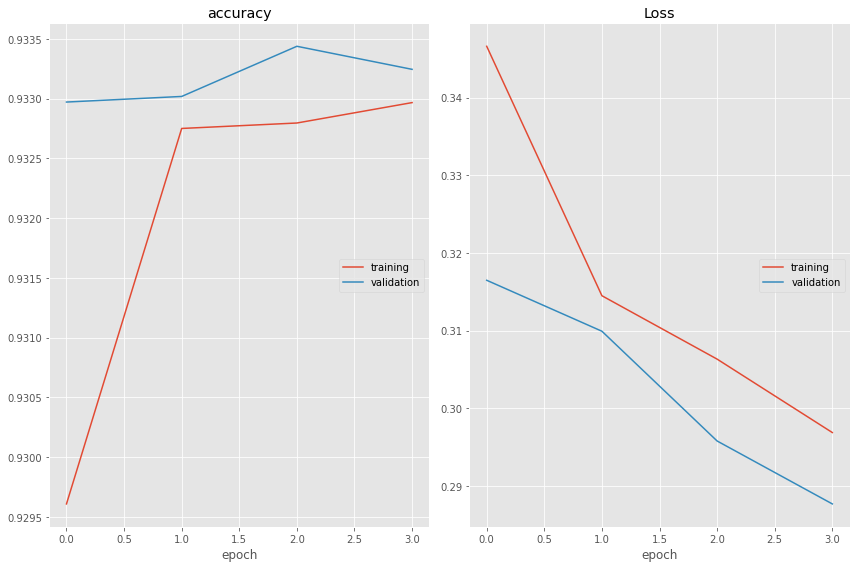

accuracy
	training         	 (min:    0.930, max:    0.933, cur:    0.933)
	validation       	 (min:    0.933, max:    0.933, cur:    0.933)
Loss
	training         	 (min:    0.297, max:    0.347, cur:    0.297)
	validation       	 (min:    0.288, max:    0.316, cur:    0.288)
480/480 [==============================] - 115s 239ms/step - loss: 0.2969 - accuracy: 0.9330 - val_loss: 0.2877 - val_accuracy: 0.9332


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1, verbose=0, mode='max',restore_best_weights= False)
callbacks = [PlotLossesCallback(),early_stopping]

history2 = model.fit(X_train,np.array(y_train),validation_split = 0.2,
                   batch_size = 64, epochs = 30, verbose=1,callbacks=callbacks)

In [ ]:
### Evaluate Named Entity Model

In [ ]:
eval = model.evaluate(X_test, np.array(y_test))

300/300 [==============================] - 12s 38ms/step - loss: 0.3121 - accuracy: 0.9336


### Compute the metrics score

In [ ]:
X_test.shape[0]

9592

Generate data in the format:
[[sentence: {start_index, end_index, text, type}]]

In [ ]:
def splitTags(tag):
    # Split tag e.g B-geo into B, GEO
    return [tag.upper() for tag in tag.split('-')]

def zipText2Tags(words, start_index, end_index, tag):
    return {'start_idx': start_index, 'end_idx': end_index, 'text': words, 'type': tag}

# Test
splitTags('B-geo')

['B', 'GEO']

In [ ]:
tags

['I-art',
 'I-eve',
 'I-per',
 'B-org',
 'B-per',
 'O',
 'B-nat',
 'I-geo',
 'I-org',
 'I-nat',
 'B-tim',
 'B-geo',
 'I-gpe',
 'B-art',
 'I-tim',
 'B-eve',
 'B-gpe']

In [ ]:
from tqdm import tqdm
sents_words = []
sents_true_labels = []
sents_pred_labels = []

p = model.predict(np.array(X_test))
p = np.argmax(p, axis=-1)
# y_true = np.argmax(np.array(y_test), axis=1)

for sent in tqdm(range(X_test.shape[0])):
    # Predict the word in each sentence
    # p = model.predict(np.array([X_test[sent]]))
    # p = np.argmax(p, axis=-1)
    y_true = np.argmax(np.array(y_test[sent]), axis=1)
    # print(X_test[sent], y_true[sent], p[sent])
    for W, true, pred in zip(X_test[sent], y_true, p[sent]):
        word = words[W-1]
        sents_words.append(word)
        sents_true_labels.append(splitTags(tags[true])[-1])
        sents_pred_labels.append(splitTags(tags[pred])[-1])
        # print("{:15}{}\t{}".format(words[W-1], tags[true], tags[pred]))

100%|██████████| 9592/9592 [00:02<00:00, 3588.20it/s]


In [ ]:
print(len(sents_words), len(sents_true_labels), len(sents_pred_labels))

479600 479600 479600


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
# dataframe_pred = pd.DataFrame.from_records(sents_true_labels)

print('Metrics Score Analysis\n\n')
print(classification_report(sents_true_labels, sents_pred_labels))
print('\nConfusion Matrix: \n', confusion_matrix(sents_true_labels, sents_pred_labels))

Metrics Score Analysis


              precision    recall  f1-score   support

         ART       0.00      0.00      0.00       182
         EVE       0.00      0.00      0.00       152
         GEO       0.60      0.01      0.03      8829
         GPE       0.00      0.00      0.00      3206
         NAT       0.00      0.00      0.00        50
           O       0.93      1.00      0.97    447795
         ORG       0.00      0.00      0.00      7162
         PER       0.14      0.00      0.00      6783
         TIM       0.08      0.00      0.00      5441

    accuracy                           0.93    479600
   macro avg       0.20      0.11      0.11    479600
weighted avg       0.89      0.93      0.90    479600


Confusion Matrix: 
 [[     0      0      0      0      0    182      0      0      0]
 [     0      0      0      0      0    152      0      0      0]
 [     0      0    130      0      0   8697      1      0      1]
 [     0      0      1      0      0   3205      0 